# Exercise 5: Logistic Regression

## Imports

In [67]:
using Pkg
Pkg.add("Flux")
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("MLBase")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
   Installed MLBase ─ v0.9.2
    Updating `~/.julia/environments/v1.11/Project.toml`
  [f0e99cf1] + MLBase v0.9.2
    Updating `~/.julia/environments/v1.11/Manifest.toml`
  [f0e99cf1] + MLBase v0.9.2
Precompiling project...
    899.7 ms  ✓ MLBase
  1 dependency successfully precompiled in 1 seconds. 499 already precompiled.


## Load Data

In [2]:
using CSV, DataFrames

# Cargar datos
data = CSV.read("julia/src/student_submissions/logistic_regression/aleman_juan/log_aleman_juan/exercise_five/data/Churn_Modelling.csv", DataFrame)

# Visualizar los datos
first(data, 5)

Row,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
,Int64,Int64,String31,Int64,String7,String7,Int64,Int64,Float64,Int64,Int64,Int64,Float64,Int64
1,1,15634602,Hargrave,619,France,Female,42,2,0.0,1,1,1,1.01349e5,1
2,2,15647311,Hill,608,Spain,Female,41,1,83807.9,1,0,1,1.12543e5,0
3,3,15619304,Onio,502,France,Female,42,8,1.59661e5,3,1,0,1.13932e5,1
4,4,15701354,Boni,699,France,Female,39,1,0.0,2,0,0,93826.6,0
5,5,15737888,Mitchell,850,Spain,Female,43,2,1.25511e5,1,1,1,79084.1,0


## Preprocess

In [3]:
using CSV, DataFrames, Flux, Statistics

# Eliminar columnas irrelevantes
data_clean = select(data, Not([:RowNumber, :CustomerId, :Surname]))

# One-hot encoding para 'Gender'
gender_encoded = Flux.onehotbatch(data_clean.Gender, ["Male", "Female"])'
gender_encoded_df = DataFrame(gender_encoded, [:is_male, :is_female])

# One-hot encoding para 'Geography'
geography_encoded = Flux.onehotbatch(data_clean.Geography, ["France", "Spain", "Germany"])'
geography_encoded_df = DataFrame(geography_encoded, [:is_france, :is_spain, :is_germany])

# Combinar las columnas codificadas
data_clean = hcat(data_clean[:, Not([:Gender, :Geography])], gender_encoded_df, geography_encoded_df)

# Separar características y etiquetas
X = select(data_clean, Not(:Exited)) |> Matrix
y = data_clean.Exited

# Normalizar las características
X_normalized = (X .- mean(X, dims=1)) ./ std(X, dims=1)


10000×13 Matrix{Float64}:
 -0.326205    0.293503    -1.04171     …   0.997154  -0.57378  -0.578707
 -0.440014    0.198154    -1.38747        -1.00275    1.74265  -0.578707
 -1.53672     0.293503     1.03286         0.997154  -0.57378  -0.578707
  0.501496    0.00745628  -1.38747         0.997154  -0.57378  -0.578707
  2.06378     0.388852    -1.04171        -1.00275    1.74265  -0.578707
 -0.0572024   0.4842       1.03286     …  -1.00275    1.74265  -0.578707
  1.77409     1.05629      0.687096        0.997154  -0.57378  -0.578707
 -2.84035    -0.946032    -0.350186       -1.00275   -0.57378   1.72782
 -1.54706     0.4842      -0.350186        0.997154  -0.57378  -0.578707
  0.346302   -1.13673     -1.04171         0.997154  -0.57378  -0.578707
  ⋮                                    ⋱   ⋮                   
 -0.553823    1.34234     -0.350186        0.997154  -0.57378  -0.578707
  0.780845   -0.27859     -1.04171        -1.00275    1.74265  -0.578707
 -0.0675487  -1.04138      0.687096

## Create Model

In [55]:
using Flux

# Modelo
model = Chain(
    Dense(13, 1, identity),  # 13 entradas, 1 salida
    σ                        # Función sigmoide
)

# Función de pérdida
loss(x, y, model) = Flux.logitbinarycrossentropy(model(x), y)


loss (generic function with 3 methods)

## Fit Model

In [59]:
# Predecir explícitamente usando W y b
function predict(x, W, b)
    W * x .+ b
end

# Función de pérdida explícita que utiliza W y b
function loss(x, y, W, b)
    preds = predict(x, W, b)
    Flux.logitbinarycrossentropy(preds, y)
end

# Calcular gradientes explícitos
grads = gradient((W, b) -> loss(X_train, y_train, W, b), W, b)
println(grads)


(Float32[-0.10139637 -0.08910752 -0.03646737 -0.048569106 0.0040762867 -0.06895427 0.02258209 -0.03111796 -0.033713453 0.033713453 0.104985036 0.027304519 -0.14826858], Float32[0.29624474])


In [65]:
function custom_train!(X, y, W, b, epochs, learning_rate)
    for epoch in 1:epochs
        # Calcular gradientes explícitos
        grads = gradient((W, b) -> loss(X, y, W, b), W, b)
        
        # Acceder a los gradientes por su posición
        dW, db = grads[1], grads[2]  # Primer y segundo elemento de la tupla
        
        # Actualizar los parámetros
        W .-= learning_rate .* dW
        b .-= learning_rate .* db
        
        # Mostrar pérdida cada 10 épocas
        if epoch % 10 == 0
            println("Epoch $epoch, Loss: $(loss(X, y, W, b))")
        end
    end
end

# Llamar a la función de entrenamiento
W, b = model[1].weight, model[1].bias  # Inicializar parámetros
custom_train!(X_train, y_train, W, b, 100, 0.01)


Epoch 10, Loss: 0.7412357
Epoch 20, Loss: 0.7271098
Epoch 30, Loss: 0.71367234
Epoch 40, Loss: 0.7008939
Epoch 50, Loss: 0.68874556
Epoch 60, Loss: 0.6771988
Epoch 70, Loss: 0.66622585
Epoch 80, Loss: 0.6557995
Epoch 90, Loss: 0.6458936
Epoch 100, Loss: 0.6364824


## Evaluation

In [69]:
function confusion_matrix(y_true, y_pred)
    TP = sum((y_true .== 1) .& (y_pred .== 1))
    TN = sum((y_true .== 0) .& (y_pred .== 0))
    FP = sum((y_true .== 0) .& (y_pred .== 1))
    FN = sum((y_true .== 1) .& (y_pred .== 0))
    println("Matriz de confusión:")
    println("TP: $TP, TN: $TN, FP: $FP, FN: $FN")
    return TP, TN, FP, FN
end

confusion_matrix (generic function with 1 method)

In [71]:
using MLBase

# Predicciones (clasificación binaria con umbral 0.5)
y_pred = predict(X_train, W, b) .> 0.5  # Genera valores true/false
y_true = vec(y_train)  # Asegúrate de que y_train sea un vector 1D para comparar

# Matriz de confusión
conf_matrix = confusion_matrix(y_pred, y_true)
println("Matriz de confusión:")
println(conf_matrix)

# Precisión
accuracy = sum(y_pred .== y_true) / length(y_true)
println("Precisión: ", accuracy)


Matriz de confusión:
TP: 2978094, TN: 67988094, FP: 17391906, FN: 11641906
Matriz de confusión:
(2978094, 67988094, 17391906, 11641906)
Precisión: 7096.6188


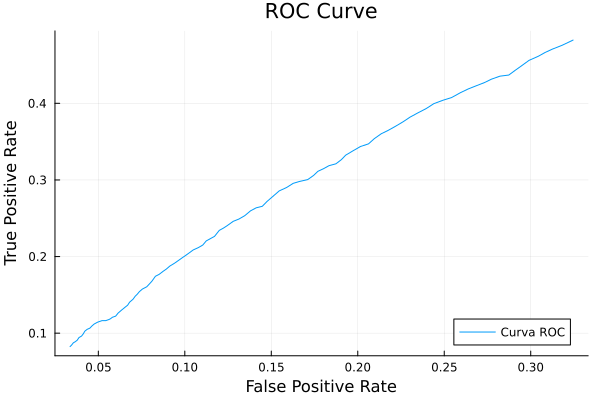

In [73]:
using Plots

# Probabilidades predichas
probs = vec(predict(X_train, W, b))  # Asegúrate de que sea un vector 1D
y_true = vec(y_train)  # Etiquetas reales (también como vector 1D)

# Crear listas para TPR y FPR
tprs = Float64[]
fprs = Float64[]
thresholds = range(0.0, 1.0, length=100)  # 100 umbrales entre 0 y 1

for threshold in thresholds
    # Clasificar según el umbral
    y_pred = probs .> threshold
    
    # Calcular TP, FP, TN, FN
    TP = sum((y_pred .== 1) .& (y_true .== 1))
    FP = sum((y_pred .== 1) .& (y_true .== 0))
    TN = sum((y_pred .== 0) .& (y_true .== 0))
    FN = sum((y_pred .== 0) .& (y_true .== 1))
    
    # Calcular TPR (Sensibilidad) y FPR
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)
    
    # Agregar a las listas
    push!(tprs, tpr)
    push!(fprs, fpr)
end

# Graficar la curva ROC
plot(fprs, tprs, label="Curva ROC", xlabel="False Positive Rate", ylabel="True Positive Rate", title="ROC Curve", legend=:bottomright)
